In [25]:
import pandas as pd
import re
import string
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Baca data
df_asli = pd.read_csv("Data_Ulasan_MYBCA.csv")

# Casefolding
def casefolding(text):
    text = str(text).lower()
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # hapus emoji / karakter non-ASCII
    text = text.translate(str.maketrans('', '', string.punctuation))  # hapus tanda baca
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi ganda
    return text

# Tokenizing
def tokenizing(text):
    return word_tokenize(text)

# Stemming
def simple_stem(word):
    suffixes = ['kah', 'nya', 'tah', 'pun', 'ku', 'mu', 'kan', 'an', 'nya']
    for suf in suffixes:
        if word.endswith(suf) and len(word) > len(suf) + 2:
            return word[:-len(suf)]
    return word

def stemming(tokens):
    return [simple_stem(token) for token in tokens]

# Filtering
stopwords = set([
    'yang','dan','di','ke','dari','untuk','dengan','pada','ini','itu','karena','dalam',
    'atau','ada','jadi','saya','kami','kita','kamu','dia','mereka','akan','bisa','tidak',
    'ya','nah','kok','kan','lah','dong','deh','tapi','lagi'
])

def filtering(tokens):
    filtered = []
    for token in tokens:
        token = re.sub(r'(.)\1+$', r'\1', token)  # hapus huruf berulang di akhir
        if token not in stopwords and len(token) >= 4:
            filtered.append(token)
    return filtered

# Save data
hasil = []
for teks in df_asli["Ulasan Teks"]:
    teks_case = casefolding(teks)
    tokens = tokenizing(teks_case)
    tokens_stem = stemming(tokens)
    tokens_filter = filtering(tokens_stem)
    teks_bersih = ' '.join(tokens_filter)
    hasil.append([teks, teks_case, tokens, tokens_stem, tokens_filter, teks_bersih])

df_hasil = pd.DataFrame(hasil, columns=[
    "Ulasan Asli", "Casefolding", "Tokenizing", "Stemming", "Filtering", "Ulasan_Bersih"
])

output_file = "Hasil_Preprocessing_Ulasan_MYBCA.xlsx"
df_hasil.to_excel(output_file, index=False)

print(f"✅ File preprocessing berhasil dibuat: {output_file}")
print(df_hasil.head(10))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


✅ File preprocessing berhasil dibuat: Hasil_Preprocessing_Ulasan_MYBCA.xlsx
                                         Ulasan Asli  \
0                                              bagus   
1  Hallo BCA kenapa sekarang aktifkan mbanking su...   
2                                                oke   
3                         ganguan woyy cepat perbiki   
4  aku baru buka rekening BCA disini, dan udah be...   
5             ini dipakai sama mamah ku atau ayah ku   
6                                              bagus   
7  registrasi berulang ulang gak pernah bisa... m...   
8                                            praktis   
9              bagaimana cara agar notifikasi muncul   

                                         Casefolding  \
0                                              bagus   
1  hallo bca kenapa sekarang aktifkan mbanking su...   
2                                                oke   
3                         ganguan woyy cepat perbiki   
4  aku baru buka rekening b

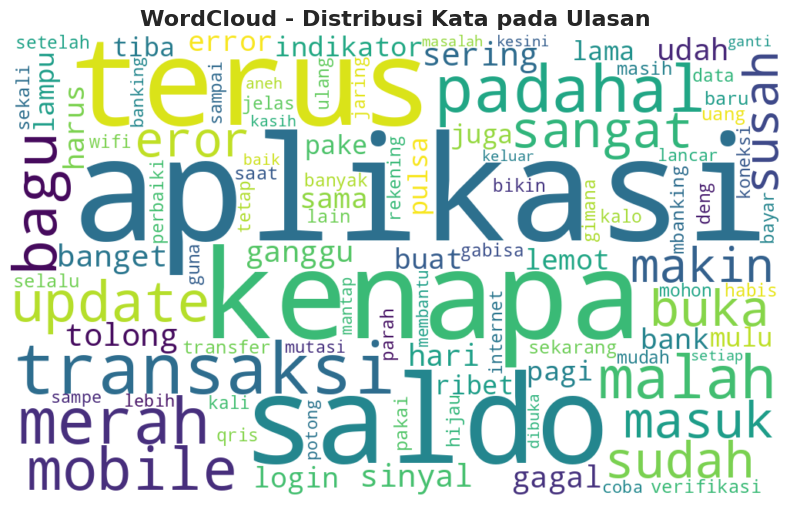

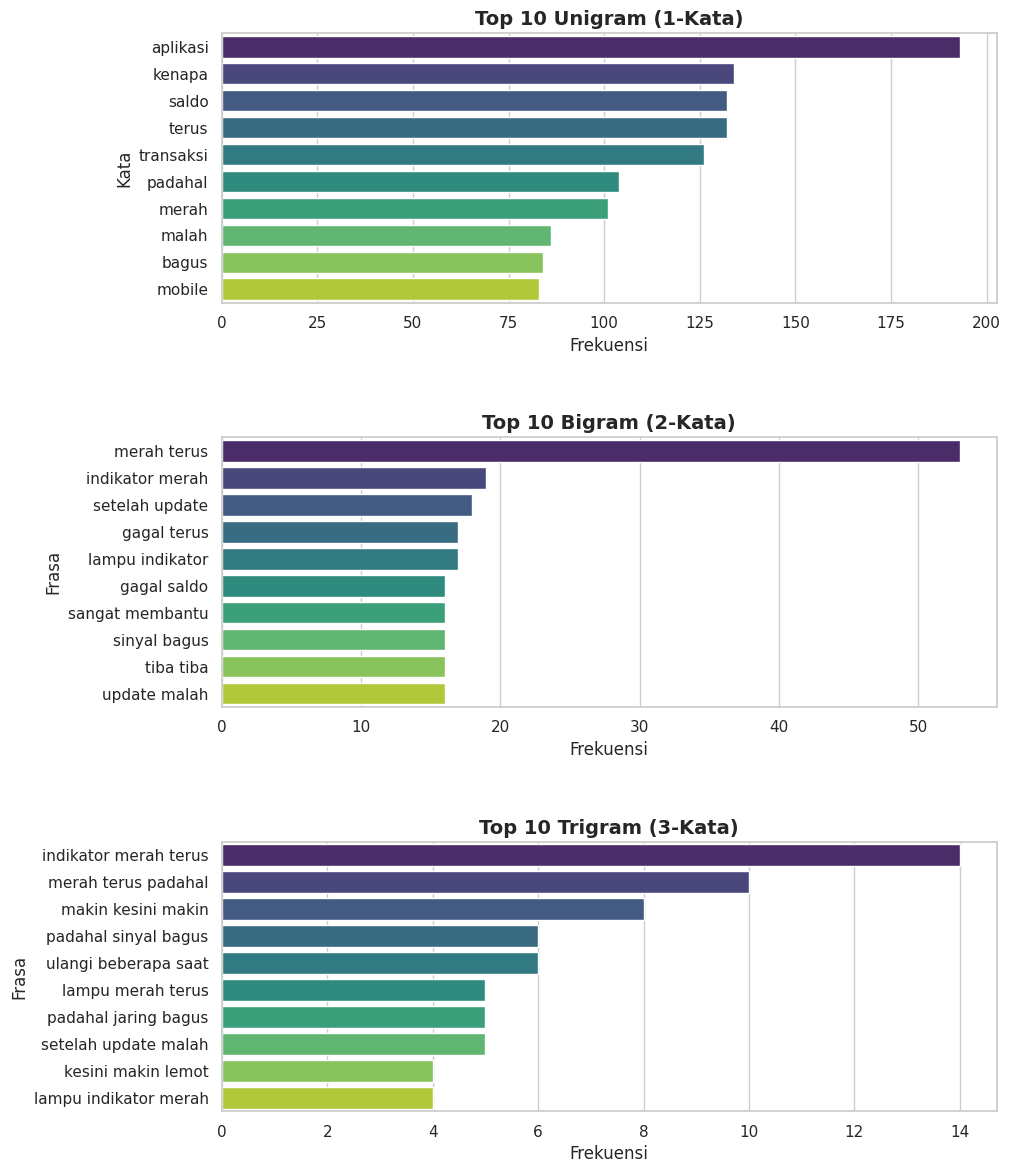

In [27]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Baca data
df = pd.read_excel("Hasil_Preprocessing_Ulasan_MYBCA.xlsx")

# Fill NaN values in "Ulasan_Bersih" with empty strings
df["Ulasan_Bersih"] = df["Ulasan_Bersih"].fillna('')

# N-gram
def get_top_ngrams(corpus, n=None, ngram_range=(1,1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    freqs = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    sorted_freqs = sorted(freqs, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(sorted_freqs[:n], columns=['Kata/Frasa', 'Frekuensi'])

# Top 10 untuk 1, 2, dan 3-gram
top_1gram = get_top_ngrams(df["Ulasan_Bersih"], n=10, ngram_range=(1,1))
top_2gram = get_top_ngrams(df["Ulasan_Bersih"], n=10, ngram_range=(2,2))
top_3gram = get_top_ngrams(df["Ulasan_Bersih"], n=10, ngram_range=(3,3))

# Visualisasi
sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis", 10)

# Plot WordCloud
all_text = ' '.join(df["Ulasan_Bersih"].astype(str))
wordcloud = WordCloud(width=1000, height=600, background_color='white',
                      colormap='viridis', collocations=False, max_words=100).generate(all_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Distribusi Kata pada Ulasan", fontsize=16, weight='bold')
plt.show()

# Chart batang top n-gram
fig, axes = plt.subplots(3, 1, figsize=(10, 14))
fig.subplots_adjust(hspace=0.5)

# Explicitly set hue and legend for bar plots to avoid FutureWarning
sns.barplot(ax=axes[0], data=top_1gram, x='Frekuensi', y='Kata/Frasa', hue='Kata/Frasa', palette=palette, legend=False)
axes[0].set_title("Top 10 Unigram (1-Kata)", fontsize=14, weight='bold') # Removed special character
axes[0].set_xlabel("Frekuensi")
axes[0].set_ylabel("Kata")

sns.barplot(ax=axes[1], data=top_2gram, x='Frekuensi', y='Kata/Frasa', hue='Kata/Frasa', palette=palette, legend=False)
axes[1].set_title("Top 10 Bigram (2-Kata)", fontsize=14, weight='bold') # Removed special character
axes[1].set_xlabel("Frekuensi")
axes[1].set_ylabel("Frasa")

sns.barplot(ax=axes[2], data=top_3gram, x='Frekuensi', y='Kata/Frasa', hue='Kata/Frasa', palette=palette, legend=False)
axes[2].set_title("Top 10 Trigram (3-Kata)", fontsize=14, weight='bold') # Removed special character
axes[2].set_xlabel("Frekuensi")
axes[2].set_ylabel("Frasa")

plt.show()